In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset_dir = r"C:\Users\Marvin\Documents\WBS\Final_Project\Data\data"
test_dir = r"C:\Users\Marvin\Documents\WBS\Final_Project\Data\test_data"

class_samples = {class_name: len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in os.listdir(dataset_dir)}
classes_to_remove = [class_name for class_name, num_samples in class_samples.items() if num_samples < 9]
test_samples = [class_name for class_name in os.listdir(test_dir)]
train_samples = [class_name for class_name in os.listdir(dataset_dir)]

input_size = (256, 256)
batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=10,
    vertical_flip=True,
    validation_split=0.2,
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,   # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,   # divide each input by its std
)


train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    classes=[class_name for class_name in os.listdir(dataset_dir) 
        if class_name not in classes_to_remove and class_name in test_samples]
)

validation_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    classes=[class_name for class_name in os.listdir(dataset_dir) 
        if class_name not in classes_to_remove and class_name in test_samples],
    shuffle=False
)

test_data_gen = ImageDataGenerator(rescale = 1./255)
test_ds = test_data_gen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    classes=[class_name for class_name in os.listdir(test_dir) if class_name not in classes_to_remove and class_name in train_samples],
    shuffle=False
)

Found 68858 images belonging to 62 classes.
Found 17188 images belonging to 62 classes.
Found 620 images belonging to 62 classes.


In [5]:
class_indices = train_ds.class_indices
samples_per_class = train_ds.classes
num_samples = {class_label: sum(samples_per_class == class_idx) for class_label, class_idx in class_indices.items()}
for class_label, num_sample in num_samples.items():
    print(f"{class_label} : {num_sample}")

Apple___alternaria_leaf_spot : 215
Apple___black_rot : 489
Apple___brown_spot : 164
Apple___gray_spot : 308
Apple___healthy : 2048
Apple___rust : 985
Apple___scab : 970
Bell_pepper___bacterial_spot : 790
Bell_pepper___healthy : 1175
Blueberry___healthy : 1194
Cassava___bacterial_blight : 862
Cassava___brown_streak_disease : 1744
Cassava___green_mottle : 1901
Cassava___healthy : 2054
Cassava___mosaic_disease : 3895
Cherry___healthy : 676
Cherry___powdery_mildew : 834
Corn___common_rust : 946
Corn___gray_leaf_spot : 403
Corn___healthy : 922
Corn___northern_leaf_blight : 780
Grape___black_measles : 1809
Grape___black_rot : 936
Grape___healthy : 1036
Grape___leaf_blight : 853
Orange___citrus_greening : 4398
Peach___bacterial_spot : 1830
Peach___healthy : 280
Potato___bacterial_wilt : 448
Potato___early_blight : 2095
Potato___healthy : 1091
Potato___late_blight : 792
Potato___nematode : 47
Potato___pests : 481
Potato___phytophthora : 270
Potato___virus : 418
Raspberry___healthy : 289
Rice__

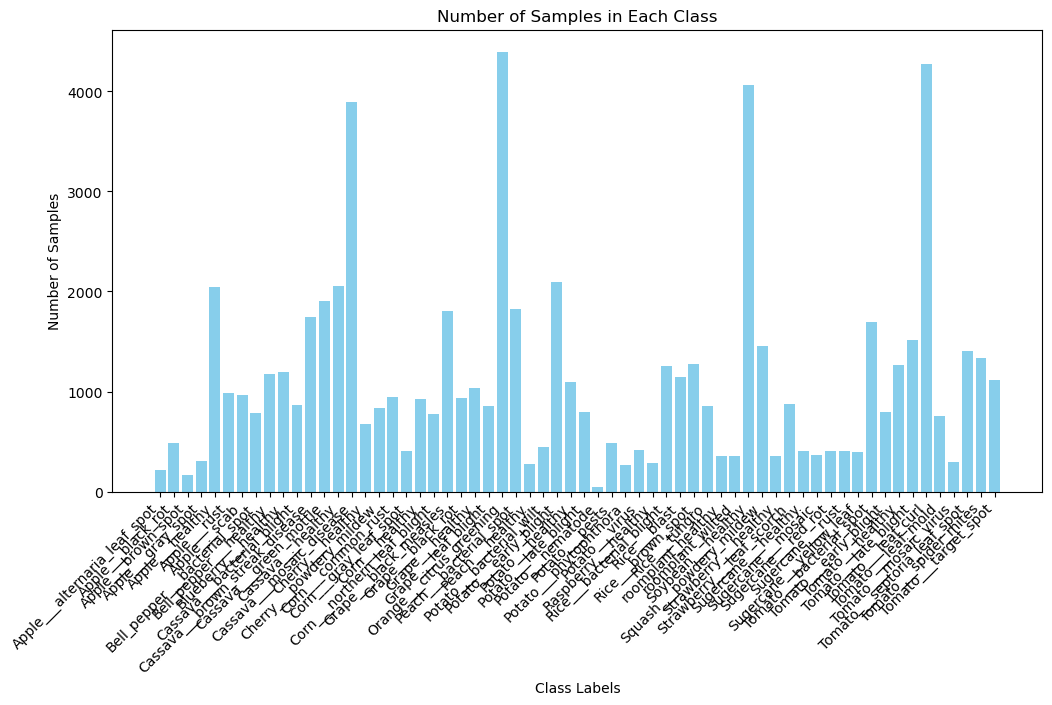

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(num_samples.keys(), num_samples.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [7]:
class_indices = test_ds.class_indices
samples_per_class = test_ds.classes
num_samples = {class_label: sum(samples_per_class == class_idx) for class_label, class_idx in class_indices.items()}
for class_label, num_sample in num_samples.items():
    print(f"{class_label}: {num_sample}")

Apple___alternaria_leaf_spot: 10
Apple___black_rot: 10
Apple___brown_spot: 10
Apple___gray_spot: 10
Apple___healthy: 10
Apple___rust: 10
Apple___scab: 10
Bell_pepper___bacterial_spot: 10
Bell_pepper___healthy: 10
Blueberry___healthy: 10
Cassava___bacterial_blight: 10
Cassava___brown_streak_disease: 10
Cassava___green_mottle: 10
Cassava___healthy: 10
Cassava___mosaic_disease: 10
Cherry___healthy: 10
Cherry___powdery_mildew: 10
Corn___common_rust: 10
Corn___gray_leaf_spot: 10
Corn___healthy: 10
Corn___northern_leaf_blight: 10
Grape___black_measles: 10
Grape___black_rot: 10
Grape___healthy: 10
Grape___leaf_blight: 10
Orange___citrus_greening: 10
Peach___bacterial_spot: 10
Peach___healthy: 10
Potato___bacterial_wilt: 10
Potato___early_blight: 10
Potato___healthy: 10
Potato___late_blight: 10
Potato___nematode: 10
Potato___pests: 10
Potato___phytophthora: 10
Potato___virus: 10
Raspberry___healthy: 10
Rice___bacterial_blight: 10
Rice___blast: 10
Rice___brown_spot: 10
Rice___tungro: 10
roompla

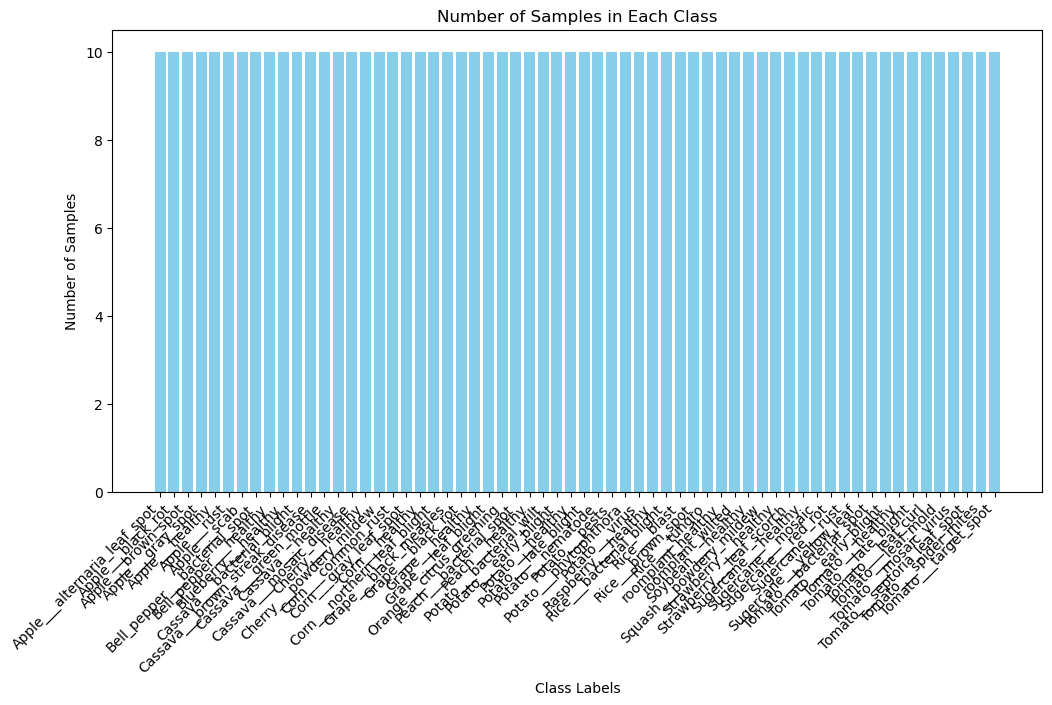

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(num_samples.keys(), num_samples.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [9]:
train_class_labels = list(train_ds.class_indices.keys())
num_classes = len(train_class_labels)

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Create a new model on top
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

# Dropout Layer zur Verringerung von Overfitting
model.add(Dropout(0.5))  # Dropout-Rate von 0.5

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

# Output layer for multiple classes with softmax activation
model.add(Dense(num_classes, activation='softmax'))

In [13]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

true_labels = validation_ds.classes
class_indices = np.unique(true_labels)

class_weights = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(true_labels), 
    y = true_labels)
class_weights = dict(enumerate(class_weights))

In [16]:
epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[early_stopping],
    class_weight=class_weights
)

c:\Users\Marvin\miniconda3\envs\myenv\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\Marvin\miniconda3\envs\myenv\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
2152/2152 [==============================] - 1139s 527ms/step - loss: 1.8880 - accuracy: 0.4499 - val_loss: 1.5202 - val_accuracy: 0.5513
Epoch 2/50
2152/2152 [==============================] - 1071s 498ms/step - loss: 1.2019 - accuracy: 0.6112 - val_loss: 1.1821 - val_accuracy: 0.6402
Epoch 3/50
2152/2152 [==============================] - 1044s 485ms/step - loss: 1.0121 - accuracy: 0.6603 - val_loss: 1.1396 - val_accuracy: 0.6559
Epoch 4/50
2152/2152 [==============================] - 1048s 487ms/step - loss: 0.8996 - accuracy: 0.6928 - val_loss: 0.9812 - val_accuracy: 0.6939
Epoch 5/50
2152/2152 [==============================] - 1049s 487ms/step - loss: 0.8154 - accuracy: 0.7167 - val_loss: 0.9509 - val_accuracy: 0.7110
Epoch 6/50
2152/2152 [==============================] - 1045s 486ms/step - loss: 0.7581 - accuracy: 0.7338 - val_loss: 0.8622 - val_accuracy: 0.7324
Epoch 7/50
2152/2152 [==============================] - 1044s 485ms/step - loss: 0.7215 - accuracy: 0.7440

: 

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
predictions = model.predict(validation_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = validation_ds.classes

print(classification_report(true_labels, predicted_labels, sample_weight=np.array([class_weights[i] for i in true_labels])))

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_ds.classes

print(classification_report(true_labels, predicted_labels))

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=train_class_labels, yticklabels=train_class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()